# Playground

## Test 2D Wavelet Decomposition function
This function(fwdHaarDWT2D) computes the 2D Wavelet Transform in the image. All the input images are passed through a Haar Wavelet Decomposition module, to get the LL, LH, HL and HHH component of the image.

/Users/jorgecamero/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


[Errno 2] No such file or directory: 'src'
/Users/jorgecamero/Moire-Pattern-Detection-Update/src


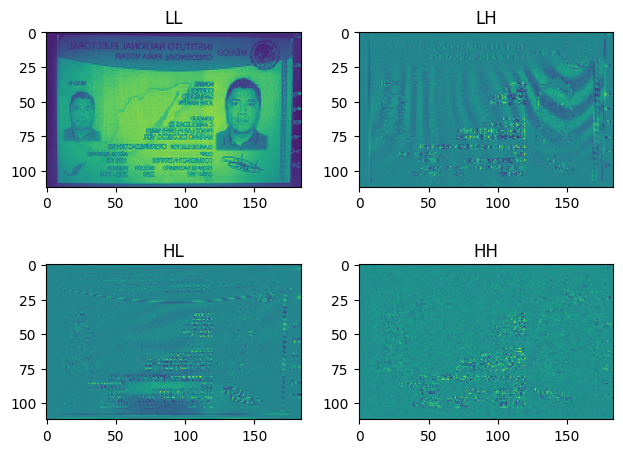

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import pywt
import numpy as np
import pywt.data
%cd src

def fwd(img):
    coeffs2 = pywt.wavedec2(img, 'bior2.2', level=3)
    LL, (HL, LH, HH) = coeffs2[0], coeffs2[1]
    return LL, LH, HL, HH

root = "/Users/jorgecamero/Downloads/bi1723070630.737285-3_front_large.jpg"
#root = "/Users/jorgecamero/Downloads/bi1723045253.0764456-3_front_large.jpg"
img = Image.open(root).convert('L')
img = img.transpose(Image.FLIP_LEFT_RIGHT)
#img.save('chl.jpg')
LL, LH, HL, HH = fwd(img)
LH2 = Image.fromarray(LH)
LH2 = LH2.resize((1400, 800), Image.LANCZOS)
# LH2_I = LH2.convert('L')
LH2.save('/Users/jorgecamero/Downloads/bi1723070630.737285-3_front_large_LH.tiff')
LH2 = np.array(LH)
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
axes[0, 0].imshow(LL)
axes[0, 1].imshow(LH)
axes[1, 0].imshow(HL)
axes[1, 1].imshow(HH)
axes[0, 0].set_title("LL")
axes[0, 1].set_title("LH")
axes[1, 0].set_title("HL")
axes[1, 1].set_title("HH")
plt.show()

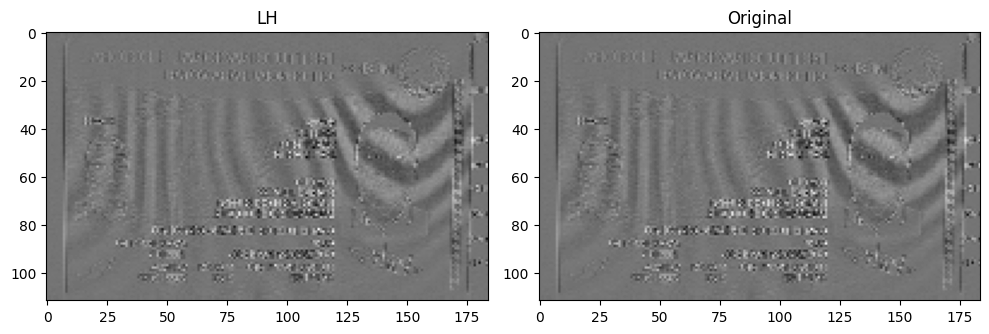

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(LH, cmap='gray')
axes[0].set_title('LH')
axes[0].axis('on')

axes[1].imshow(LH2, cmap='gray')
axes[1].set_title('Original')
axes[1].axis('on')

plt.tight_layout()
plt.show()

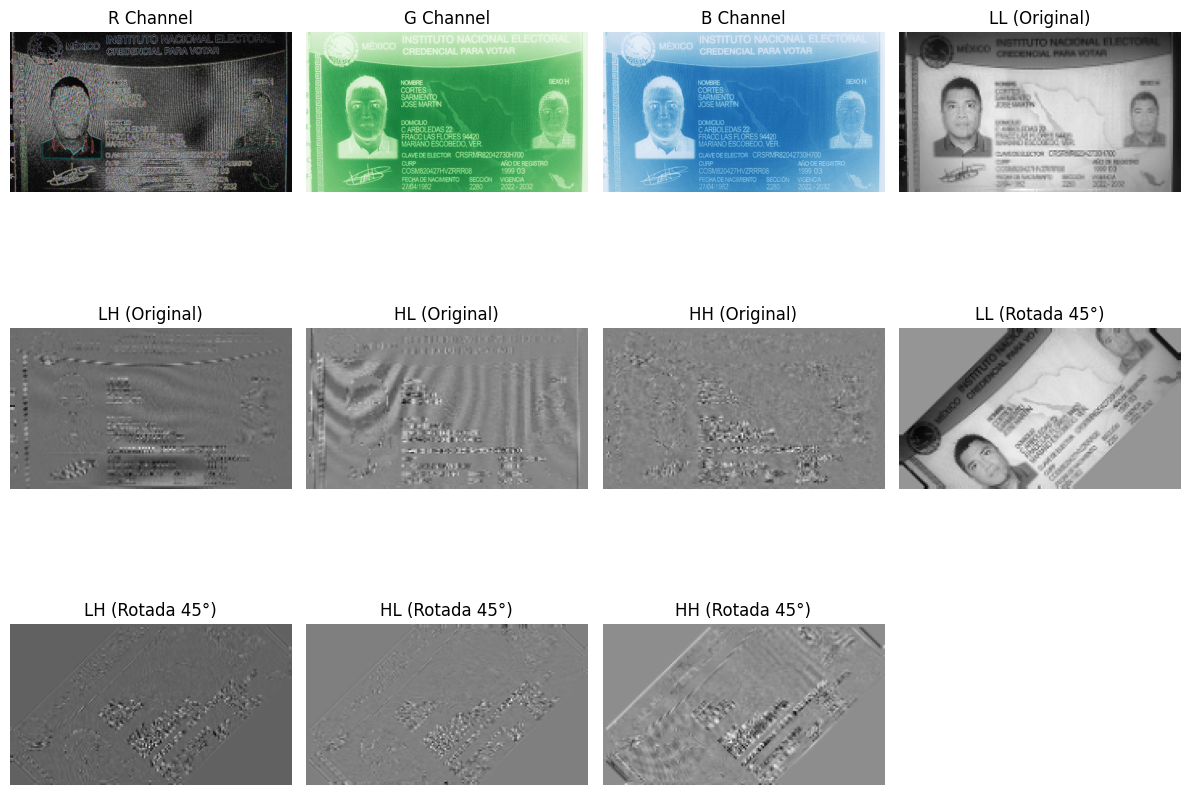

In [279]:

import tensorflow as tf
import numpy as np
import cv2
from scipy.ndimage import rotate

HEIGHT = 800
WIDTH = 1400

def crop(image, target_height, target_width):
    image = tf.convert_to_tensor(image)
    
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]
    
    offset_height = (original_height - target_height) // 2
    offset_width = (original_width - target_width) // 2
    
    cropped_image = image[
        offset_height:offset_height + target_height,
        offset_width:offset_width + target_width,
    ]
    
    return cropped_image

def wavelet_transform(image, wavelet='bior2.2', level=3):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    LL, (LH, HL, HH) = coeffs[0], coeffs[1]
    return LL, LH, HL, HH

def resize(component, target_height, target_width):
    component_resized = tf.image.resize(component, (int(target_height), int(target_width)), method='bilinear')
    return component_resized

def sobel(img):
    image_np = img.numpy()

    sobel_x = cv2.Sobel(image_np, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image_np, cv2.CV_64F, 0, 1, ksize=3)

    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(sobel_combined)
    
    return sobel_combined

def preprocess_image(image):
    imageCrop = crop(image, HEIGHT, WIDTH)
    
    imgSobel = sobel(imageCrop)
    
    image_gray = tf.image.rgb_to_grayscale(imageCrop)
    image_standardized = tf.image.per_image_standardization(image_gray)
    image_standardized = tf.squeeze(image_standardized, axis=-1)

    LL, LH, HL, HH = wavelet_transform(image_standardized)
    
    LL_tensor = np.expand_dims(LL, axis=-1)
    LH_tensor = np.expand_dims(LH, axis=-1)
    HL_tensor = np.expand_dims(HL, axis=-1)
    HH_tensor = np.expand_dims(HH, axis=-1)
    
    LL_resized = resize(LL_tensor, HEIGHT/8, WIDTH/8)
    LH_resized = resize(LH_tensor, HEIGHT/8, WIDTH/8)
    HL_resized = resize(HL_tensor, HEIGHT/8, WIDTH/8)
    HH_resized = resize(HH_tensor, HEIGHT/8, WIDTH/8)

    # Rotación de la imagen 45 grados
    img_rotated = rotate(image_standardized.numpy(), 45, reshape=False)
    
    # Obtención de los componentes wavelet de la imagen rotada
    LL_rot, LH_rot, HL_rot, HH_rot = wavelet_transform(img_rotated)

    # Expansión de dimensiones para los componentes rotados
    LL_rot_tensor = np.expand_dims(LL_rot, axis=-1)
    LH_rot_tensor = np.expand_dims(LH_rot, axis=-1)
    HL_rot_tensor = np.expand_dims(HL_rot, axis=-1)
    HH_rot_tensor = np.expand_dims(HH_rot, axis=-1)

    # Redimensionamiento de los componentes wavelet rotados
    LL_rot_resized = resize(LL_rot_tensor, HEIGHT/8, WIDTH/8)
    LH_rot_resized = resize(LH_rot_tensor, HEIGHT/8, WIDTH/8)
    HL_rot_resized = resize(HL_rot_tensor, HEIGHT/8, WIDTH/8)
    HH_rot_resized = resize(HH_rot_tensor, HEIGHT/8, WIDTH/8)

    # Separar los canales RGB
    RGB_Input = np.array(imageCrop)  # Asegurarse de que sea un tensor 3D
    RGB_Input = tf.image.per_image_standardization(RGB_Input)

    R, G, B = tf.split(RGB_Input, 3, axis=-1)

    return {
        'LL_Input': LL_resized,
        'LH_Input': LH_resized,
        'HL_Input': HL_resized,
        'HH_Input': HH_resized,
        'LL_Rot_Input': LL_rot_resized,
        'LH_Rot_Input': LH_rot_resized,
        'HL_Rot_Input': HL_rot_resized,
        'HH_Rot_Input': HH_rot_resized,
        'R_Input': imgSobel,
        'G_Input': G,
        'B_Input': B
    }

def main(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    components = preprocess_image(img)

    plt.figure(figsize=(12, 12))

    # Mostrar la imagen original
    plt.subplot(4, 4, 1)
    plt.imshow(components['R_Input'].squeeze())
    plt.title("R Channel")
    plt.axis('off')

    plt.subplot(4, 4, 2)
    plt.imshow(components['G_Input'].numpy().squeeze(), cmap='Greens')
    plt.title("G Channel")
    plt.axis('off')

    plt.subplot(4, 4, 3)
    plt.imshow(components['B_Input'].numpy().squeeze(), cmap='Blues')
    plt.title("B Channel")
    plt.axis('off')

    # Mostrar componentes wavelet originales
    plt.subplot(4, 4, 4)
    plt.imshow(components['LL_Input'].numpy(), cmap='gray')
    plt.title("LL (Original)")
    plt.axis('off')

    plt.subplot(4, 4, 5)
    plt.imshow(components['LH_Input'].numpy(), cmap='gray')
    plt.title("LH (Original)")
    plt.axis('off')

    plt.subplot(4, 4, 6)
    plt.imshow(components['HL_Input'].numpy(), cmap='gray')
    plt.title("HL (Original)")
    plt.axis('off')

    plt.subplot(4, 4, 7)
    plt.imshow(components['HH_Input'].numpy(), cmap='gray')
    plt.title("HH (Original)")
    plt.axis('off')

    # Mostrar componentes wavelet de la imagen rotada
    plt.subplot(4, 4, 8)
    plt.imshow(components['LL_Rot_Input'].numpy(), cmap='gray')
    plt.title("LL (Rotada 45°)")
    plt.axis('off')

    plt.subplot(4, 4, 9)
    plt.imshow(components['LH_Rot_Input'].numpy(), cmap='gray')
    plt.title("LH (Rotada 45°)")
    plt.axis('off')

    plt.subplot(4, 4, 10)
    plt.imshow(components['HL_Rot_Input'].numpy(), cmap='gray')
    plt.title("HL (Rotada 45°)")
    plt.axis('off')

    plt.subplot(4, 4, 11)
    plt.imshow(components['HH_Rot_Input'].numpy(), cmap='gray')
    plt.title("HH (Rotada 45°)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Especificar la ruta de la imagen y dimensiones
image_path = '/Users/jorgecamero/Downloads/batch/Ataque/bi1723070630.737285-3_front_large.jpg'  # Cambia esto por la ruta de tu imagen

main(image_path)

/Users/jorgecamero/Downloads/bi1722116076.066239-2_front_large.jpg


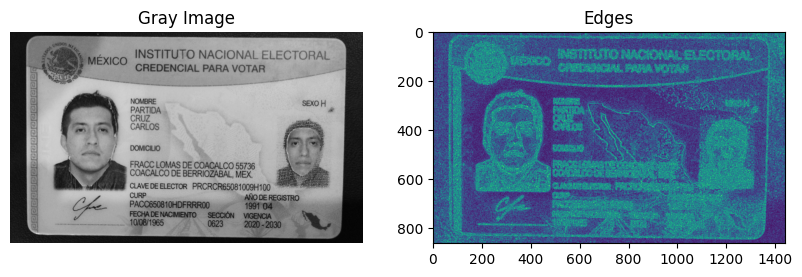

In [380]:
from skimage.filters import gabor
from os import listdir
from os.path import join
import random

root = '/Users/jorgecamero/Downloads'
listImg = [img for img in listdir(root) if img.endswith(('.jpg', '.png', '.jpeg'))]
image_path = random.choice(listImg)
image_path = join(root, image_path)
print(image_path)
#image_path = '/Users/jorgecamero/Downloads/bi1681047293.1619277-12_front_large.jpg'
#image_path = '/Users/jorgecamero/Downloads/bi1722116076.066239-2_front_large.jpg'
#image_path = '/Users/jorgecamero/Downloads/bi1722965060.5580215-13_front_large.jpg'

img = cv2.imread(image_path)
color_image = cv2.imread(image_path)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

scharr_x = cv2.Scharr(gray_image, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(gray_image, cv2.CV_64F, 0, 1)

scharr_combined = np.sqrt(scharr_x**2 + scharr_y**2)
scharr_combined = np.uint8(scharr_combined)

filtro = scharr_combined
plt.figure(figsize=(10, 5))

# Mostrar la imagen en escala de grises
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

# Mostrar la imagen con los bordes detectados
plt.subplot(1, 2, 2)
plt.imshow(filtro)
plt.title('Edges')
plt.axis('on')

plt.show()

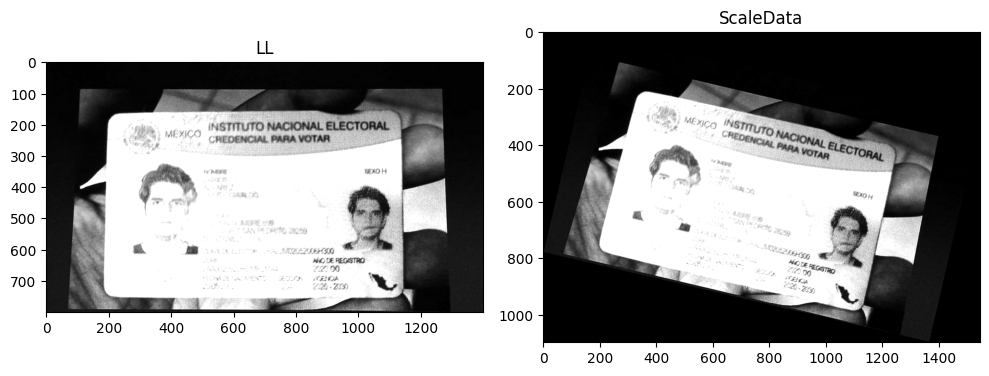

[[ 0  0  2 ...  2  2  0]
 [ 0  0  2 ...  2  2  0]
 [ 0  0  2 ...  2  2  0]
 ...
 [ 0  0 26 ... 26 26  0]
 [ 0  0 26 ... 26 26  0]
 [ 0  0 26 ... 26 26  0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import tensorflow as tf
import numpy as np
import random

def apply_augmentation(image):
    image_np = np.array(image)
    
    if len(image_np.shape) != 2:
        raise ValueError("The input image must be a 2-D grayscale image.")
    
    image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)
    image_tf = tf.expand_dims(image_tf, axis=-1)  # Añade un canal de color
    
    # Aplicar aumentos
    image_tf = tf.image.random_brightness(image_tf, max_delta=0.15)
    image_tf = tf.image.random_contrast(image_tf, lower=0.9, upper=1.1)

    image_pil = Image.fromarray(tf.squeeze(image_tf).numpy())
    
    angle = random.uniform(-20, 20)  # Ángulo entre -20 y 20 grados
    image_pil = image_pil.rotate(angle, resample=Image.BICUBIC, expand=True)
    
    # Convertir de nuevo a tensor
    image_np = np.array(image_pil)
    image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)
    image_tf = tf.expand_dims(image_tf, axis=-1)
    
    # Reescala los valores de píxeles
    image_tf = tf.clip_by_value(image_tf, 0, 255)
    image_tf = tf.cast(image_tf, dtype=tf.uint8)
    
    # Elimina el canal adicional
    image_tf = tf.squeeze(image_tf, axis=-1)
    
    # Convierte el tensor a una imagen PIL
    image_augmented = Image.fromarray(image_tf.numpy())
    
    return image_augmented

imgNew = PreprocessImage("/Users/jorgecamero/Downloads/0329_135827_6842d634_LL.tiff", 1400, 800)
imgNew2 = apply_augmentation(imgNew)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(imgNew, cmap='gray')
axes[0].set_title('LL')
axes[0].axis('on')

axes[1].imshow(imgNew2, cmap='gray')
axes[1].set_title('ScaleData')
axes[1].axis('on')

plt.tight_layout()
plt.show()

print(np.array(imgNew))
print(np.array(imgNew2))


In [ ]:
from PIL import ImageOps

def resize_and_crop(img, width, height):
    w, h = img.size
    
    if w / h > width / height:  
        proportion = width / w
    else:  
        proportion = height / h

    new_width = int(w * proportion)
    new_height = int(h * proportion)

    img = img.resize((new_width, new_height), Image.LANCZOS)

    delta_w = max(0, width - new_width)
    delta_h = max(0, height - new_height)

    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    img = ImageOps.expand(img, padding, fill="black")

    img = img.crop((0, 0, width, height))

    return img.convert('L')

root = "/Users/jorgecamero/Downloads/bi1723070630.737285-3_front_large.jpg"

img = Image.open(root)
img = img.rotate(45, expand=True)
img = resize_and_crop(img, 1400, 800)
print(img.size)
img.show()

(1400, 800)


In [ ]:
def LL_Augmentation_3D(image):
    image_np = np.array(image)

    if len(image_np.shape) != 3 or image_np.shape[2] != 3:
        raise ValueError("The input image must be a 3-D image with 3 channels (RGB).")
    
    image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)
    
    # Aplicar aumentos
    image_tf = tf.image.random_brightness(image_tf, max_delta=0.15)
    image_tf = tf.image.random_contrast(image_tf, lower=0.85, upper=1.15)
    
    image_np = image_tf.numpy().astype(np.uint8)
    image_pil = Image.fromarray(image_np)

    # Rotación aleatoria entre -20 y 20 grados
    angle = random.uniform(-20, 20)  # Ángulo entre -20 y 20 grados
    image_pil = image_pil.rotate(angle, resample=Image.BICUBIC, expand=True)
    
    image_np = np.array(image_pil)
    image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)
    
    # Clip valores entre 0 y 255, y convertir a uint8
    image_tf = tf.clip_by_value(image_tf, 0, 255)
    image_tf = tf.cast(image_tf, dtype=tf.uint8)

    # Convertir de vuelta a PIL Image
    image_augmented = Image.fromarray(image_tf.numpy())
    
    return image_augmented

# Ejemplo de uso
root = "/Users/jorgecamero/Downloads/bi1723070630.737285-3_front_large.jpg"

image = Image.open(root)
image_augmented = LL_Augmentation_3D(image)
image_augmented.show()

## Test training data creation
The training images need to be put in two folders. positiveImages and negativeImages. positiveImages are the images which are captured from the display devices and has the presence of stron or weak Moiré patterms in it.
negativeImages are the ones without Moiré Patterns (i.e. the images which are not captured from the display devices) 

In [ ]:
!python  C:/Users/jorge/Desktop/Moire/Moire-Pattern-Detection-Update/src/createTrainingData.py --origenPositiveImages C:/Users/jorge/Desktop/Moire/positiveImages --origenNegativeImages C:/Users/jorge/Desktop/Moire/negativeImages --outputPositiveImages C:/Users/jorge/Desktop/Moire/positiveImagesTraining/ --outputNegativeImages C:/Users/jorge/Desktop/Moire/negativeImagesTraining/

positive samples: 3
negative samples: 4
training image rotated
training image rotated
training image rotated
Total positive files after augmentation:  9
Total negative files after augmentation:  12


In [ ]:
!python train.py --positiveImages C:/Users/jorge/Desktop/Moire/positiveImages --negativeImages C:/Users/jorge/Desktop/Moire/negativeImages --trainingDataPositive C:/Users/jorge/Desktop/Moire/positiveImagesTraining --trainingDataNegative C:/Users/jorge/Desktop/Moire/negativeImagesTraining/ --epochs 120 --batch_size 8 --loadCheckPoint false

2024-07-18 20:35:44.520863: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 20:35:56.215882: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Traceback (most recent call last):
  File "c:\Users\jorge\Desktop\Moire\Moire-Pattern-Detection-Update\src\train.py", line 12, in <module>
    from mCNN import createModel
  File "c:\Users\jorge\Desktop\Moire\Moire-Pattern-Detection-Update\src\mCNN.py", line 57, in <module>
    import tensorflow_model_optimization as tfmot
  File "C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5

## Test CNN Evaluation

In [ ]:
!python test.py --positiveTestImages ./positiveImages --negativeTestImages ./negativeImages --batch_size 32

Training 32 images.	start: 0	end: 32	n:707
Training 32 images.	start: 32	end: 64	n:707
Batch Loss: 0.018172360956668854
Batch Accuracy: 1.0
Training 32 images.	start: 64	end: 96	n:707
Batch Loss: 0.016667252406477928
Batch Accuracy: 1.0
Training 32 images.	start: 96	end: 128	n:707
Batch Loss: 0.016768882051110268
Batch Accuracy: 1.0
Training 32 images.	start: 128	end: 160	n:707
Batch Loss: 0.015818005427718163
Batch Accuracy: 1.0
Training 32 images.	start: 160	end: 192	n:707
Batch Loss: 0.01656891033053398
Batch Accuracy: 1.0
Training 32 images.	start: 192	end: 224	n:707
Batch Loss: 0.016850318759679794
Batch Accuracy: 1.0
Training 32 images.	start: 224	end: 256	n:707
Batch Loss: 0.016491901129484177
Batch Accuracy: 1.0
Training 32 images.	start: 256	end: 288	n:707
Batch Loss: 0.017168765887618065
Batch Accuracy: 1.0
Training 32 images.	start: 288	end: 320	n:707
Batch Loss: 0.01856425777077675
Batch Accuracy: 1.0
Training 32 images.	start: 320	end: 352	n:707
Batch Loss: 0.0185407884418

2024-07-09 22:45:03.266756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 22:45:05.657162: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 22:45:14.751830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 22:45:57.328101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotu

In [ ]:
!python C:/Users/jorge/Desktop/Moire/Moire-Pattern-Detection-Update/src/createLiteModel.py --modelPath C:/Users/jorge/Desktop/Moire/cp.keras --modelLitePath C:/Users/jorge/Desktop/Moire/cp_saveModel.tflite

Saved artifact at 'C:\Users\jorge\AppData\Local\Temp\tmp0vme7r84'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 375, 500, 1), dtype=tf.float32, name='input_layer'), TensorSpec(shape=(None, 375, 500, 1), dtype=tf.float32, name='input_layer_1'), TensorSpec(shape=(None, 375, 500, 1), dtype=tf.float32, name='input_layer_2'), TensorSpec(shape=(None, 375, 500, 1), dtype=tf.float32, name='input_layer_3')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2212580480336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580481488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580480720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580481296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580479568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580480912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2212580479760: TensorSpec(shape=(),

2024-07-18 21:57:54.342449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 21:57:57.440920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 21:58:03.032449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\

In [ ]:
!python3 /Users/jorgecamero/Moire-Pattern-Detection-Update/src/trainLossModified.py --positiveImages /home/ec2-user/Moire/Moire/Real_predictions --negativeImages /home/ec2-user/Moire/Moire/Atack/trainNegatives_reshape --trainingDataPositive /home/ec2-user/Moire/Moire/positiveTraining --trainingDataNegative /home/ec2-user/Moire/Moire/negativeTraining --checkpointPath checkpointNew --epochs 1 --init_epoch 1 --save_iter 100 --batch_size 2 --height 800 --width 1400 --loadCheckPoint False

^C
Traceback (most recent call last):
  File "/Users/jorgecamero/Moire-Pattern-Detection-Update/src/trainLossModified.py", line 12, in <module>
    from mCNN import createModel
  File "/Users/jorgecamero/Moire-Pattern-Detection-Update/src/mCNN.py", line 4, in <module>
    from keras.models import Model # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/__init__.py", line 4, in <module>
    from keras.api import DTypePolicy
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/api/__init__.py", line 8, in <module>
    from keras.api import activations
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/api/activations/__init__.py", line 7, in <module>
    from keras.src.activations import deserialize
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/__init__.py", line